In [106]:
#Import Modules#

# numpy stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import *
from keras.models import *
from keras import optimizers
from keras.callbacks import *

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_score, confusion_matrix, classification_report, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import binarize
from autoencoder_BATADAL import load_AEED
from collections import Counter
from sklearn.preprocessing import label_binarize


# os and time utils
import os
import time
import glob

import pickle

In [107]:
#Autoencoder Classes#

# classes
class AutoEncoder(object):
    """ Keras-based AutoEncoder (AE) class used for event detection.

        Attributes:
        params: dictionary with parameters defining the AE structure,
    """
    def __init__(self, **kwargs):
        """ Class constructor, stores parameters and initialize AE Keras model. """
        
        # Default parameters values. If nI is not given, the code will crash later.
        params = {
            'nI': None,
            'nH': 3,
            'cf': 1,
            'activation' : 'tanh',
            'optimizer' : None,
            'verbose' : 0
            }

        for key,item in kwargs.items():
            params[key] = item
        
        self.params = params

    def create_model(self):
        """ Creates Keras AE model.

            The model has nI inputs, nH hidden layers in the encoder (and decoder)
            and cf compression factor. The compression factor is the ratio between
            the number of inputs and the innermost hidden layer which stands between
            the encoder and the decoder. The size of the hidden layers between the 
            input (output) layer and the innermost layer decreases (increase) linearly
            according to the cg.
        """
        
        # retrieve params
        nI = self.params['nI'] # number of inputs
        nH = self.params['nH'] # number of hidden layers in encoder (decoder)
        cf = self.params['cf'] # compression factor
        activation = self.params['activation'] # autoencoder activation function
        optimizer = self.params['optimizer'] # Keras optimizer
        verbose = self.params['verbose'] # echo on screen
        
        # get number/size of hidden layers for encoder and decoder
        temp = np.linspace(nI,nI/cf,nH + 1).astype(int)
        nH_enc = temp[1:]
        nH_dec = temp[:-1][::-1]

        # input layer placeholder
        input_layer = Input(shape=(nI,))

        # build encoder
        for i, layer_size in enumerate(nH_enc):
            if i == 0:
                # first hidden layer
                encoder = Dense(layer_size, activation=activation)(input_layer)
            else:
                # other hidden layers
                encoder = Dense(layer_size, activation=activation)(encoder)

        # build decoder
        for i, layer_size in enumerate(nH_dec):
            if i == 0:
                # first hidden layer
                decoder = Dense(layer_size, activation=activation)(encoder)
            else:
                # other hidden layers
                decoder = Dense(layer_size, activation=activation)(decoder)

        # create autoencoder
        autoencoder = Model(input_layer, decoder)
        if optimizer == None:
            optimizer = optimizers.Adam(lr = 0.001)

        # print autoencoder specs
        if verbose > 0:
            print('Created autoencoder with structure:');
            print(', '.join('layer_{}: {}'.format(v, i) for v, i in enumerate(np.hstack([nI,nH_enc,nH_dec]))))

        # compile and return model
        autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
        autoencoder.summary()
        return autoencoder
    
    def build_predictor(self):
        model = Sequential()
        '''
        model.add(LSTM(43,dropout_U = 0.2, dropout_W = 0.2, input_shape=(2,43)))# return_sequences=True, 
        #model.add(LSTM(43, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(Dense(43, activation = 'relu'))
        '''
        model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape = (1,43), padding='same'))
        model.add(MaxPooling1D(pool_size=1, strides=None))
        model.add(Conv1D(128, 2, activation='relu', padding='same'))
        model.add(MaxPooling1D(pool_size=1))
        model.add(Conv1D(256, 2, activation='relu', padding='same'))
        model.add(MaxPooling1D(pool_size=1))
        model.add(Flatten())
        model.add(Dropout(0.3, noise_shape=None, seed=13))
        model.add(Dense(43, activation='relu'))     
        
        model.compile(loss='mean_squared_error', optimizer=  optimizers.Adam(lr = 0.001))
        model.summary()
        return model

    def train(self, x, y, **train_params):
        """ Train autoencoder,

            x: inputs (inputs == targets, AE are self-supervised ANN).
        """        
        if self.params['verbose']:
            if self.ann == None:
                print('Creating model.')
                self.create_model()
        self.ann.fit(x, y, **train_params)


    def predict(self, x, test_params={}):
        """ Yields reconstruction error for all inputs,

            x: inputs.
        """
        return self.ann.predict(x, **test_params)

class AEED(AutoEncoder):
    """ This class extends the AutoEncoder class to include event detection
        functionalities.
    """
    
    def difference(x):
        return (x[-1] - x[0])**2
    
    def initialize(self):
        """ Create the underlying Keras model. """
        self.ann = self.create_model()#self.build_predictor()#

    def predict(self, x, y, **keras_params):
        """ Predict with autoencoder. """        
        #preds = super(AEED, self).predict(x,keras_params)
        #errors = pd.DataFrame((y-preds)**2)
        #errors_1 = np.sqrt(np.mean((y - preds)**2))
        #return preds, errors, errors_1   
        preds = super(AEED, self).predict(x,keras_params)
        errors = pd.DataFrame((y-preds)**2)
        return preds, errors 
    #changed window from 1 to 3 below    
    def detect(self, x, y, theta, window = 3, average=False, sys_theta = 0, **keras_params):
        """ Detection performed based on (smoothed) reconstruction errors.

            x = inputs,
            theta = threshold, attack flagged if reconstruction error > threshold,
            window = length of the smoothing window (default = 1 timestep, i.e. no smoothing),
            average = boolean (default = False), if True the detection is performed
                on the average reconstruction error across all outputs,
            keras_params = parameters for the Keras-based AE prediction.
        """
        #preds = super(AEED, self).predict(x,keras_params)
        preds, temp = self.predict(x, y, **keras_params)
        #temp = (x-preds)**2
        if average:
            #errors = temp.mean(axis=1).rolling(window=window).mean()             
            #detection = errors > theta
            # Calculate the rolling mean using np.convolve
            window = np.ones(window) / window
            errors = np.convolve(temp.mean(axis=1), window, mode='same')
            detection = errors > theta
        else:
            #errors = temp.rolling(window=window).mean()
            #detection = errors.apply(lambda x: x>np.max(theta.name, sys_theta)) 
            # Continue with the existing code for non-average case
            errors = temp > theta
            detection = np.any(errors, axis=1)
            
        return detection, errors

    def save(self, filename, scaler, theta):
        """ Save AEED modelself.

            AEED parameters saved in a .json, while Keras model is stored in .h5 .
        """
        # parameters
        with open(filename+'.json', 'w') as fp:
            json.dump(self.params, fp)
        # keras model
        self.ann.save(filename+'.h5')
        with open("theta", 'w') as f:
            f.write(str(theta))
        pickle.dump(scaler, open( "scaler.p", "wb" ))
        # echo
        print('Saved AEED parameters to {0}.\nKeras model saved to {1}'.format(filename+'.json', filename+'.h5'))


# functions
def load_AEED(params_filename, model_filename):
    """ Load stored AEED. """
    # load params and create AEED
    with open(params_filename) as fd:
        params = json.load(fd)
    aeed = AEED(**params)

    # load keras model
    aeed.ann = load_model(model_filename)
    return aeed


In [108]:
def create_dataset(dataset, window_size = 4):
    """ 
    Creates the dataset composed by window_size samples of sensor readings and their relative label
    
    if windows size is 2, it returns a dataset composed [[[x-1, x][x]], [[x, x+1][x+1]], ...]
    Parameters
    ----------
    dataset :  list
        list of dataset samples
    window_size : int
        number of samples used for feeding the network.

    Returns
    -------
    np array
        dataset samples organized in groups of windows_size
    np array
        target of model prediction
    """
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size + 1)] #remove +1 to turn into 1-step ahead prediction
        data_X.append(a)
        data_Y.append(dataset[i + window_size])
    return(np.array(data_X), np.array(data_Y))

In [109]:
#Load data 
df_train_orig = pd.read_csv("train1.csv", parse_dates=['Time'], dayfirst=True)


In [110]:
# get dates and columns with sensor readings
dates_train = df_train_orig['Time']
sensor_cols = [col for col in df_train_orig.columns if col not in ['Time','BLANK1','BLANK2','BLANK3']]

In [111]:
# scale sensor data
scaler = MinMaxScaler()
X =scaler.fit_transform(df_train_orig[sensor_cols])
# split into training and validation
X1, X2, _, _  = train_test_split(X, X, test_size=0.33, random_state=42, shuffle=False)
window = 0
train_X, train_Y = create_dataset(X1, window) #to use also the current reading
test_X, test_Y = create_dataset(X2, window)
print(train_X.shape)
print(test_X.shape)

(203, 1, 81)
(100, 1, 81)


In [112]:
#Train Autoencoder#

# define model parameters
params = {
    'nI' : X.shape[1],
    'nh' : 3,
    'cf' : 2.5,
    'activation' : 'tanh',
    'verbose' : 1,  
}

# create AutoEncoder for Event Detection (AEED)
autoencoder = AEED(**params)
autoencoder.initialize()

from tensorflow.keras.optimizers import Adam
# learning rate = 0.0001
optimizer = Adam(learning_rate=0.0001)
#autoencoder.compile(optimizer=optimizer, loss='mse')

Created autoencoder with structure:
layer_0: 81, layer_1: 64, layer_2: 48, layer_3: 32, layer_4: 48, layer_5: 64, layer_6: 81
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 81)]              0         
                                                                 
 dense_48 (Dense)            (None, 64)                5248      
                                                                 
 dense_49 (Dense)            (None, 48)                3120      
                                                                 
 dense_50 (Dense)            (None, 32)                1568      
                                                                 
 dense_51 (Dense)            (None, 48)                1584      
                                                                 
 dense_52 (Dense)            (None, 64)                3136      

C:\ProgramData\anaconda3\envs\py38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [113]:
# train models with early stopping and reduction of learning rate on plateau
earlyStopping= EarlyStopping(monitor='val_loss', patience=3, verbose=0,  min_delta=1e-4, mode='auto')
#lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, epsilon=1e-4, mode='min')
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, min_delta=1e-4, mode='min')
   
# initialize time
start_time = time.time()

# Remove the extra dimension from input data
train_X = np.squeeze(train_X)
test_X = np.squeeze(test_X)

# train autoencoder
autoencoder.train(train_X,train_Y,
            epochs=500,
            batch_size=32,
            shuffle=False,
            callbacks = [earlyStopping, lr_reduced],
            verbose = 2,
            validation_data=(test_X, test_Y))

print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)


Epoch 1/500
7/7 - 1s - loss: 0.2241 - val_loss: 0.1576 - lr: 0.0010 - 1s/epoch - 152ms/step
Epoch 2/500
7/7 - 0s - loss: 0.1079 - val_loss: 0.1362 - lr: 0.0010 - 62ms/epoch - 9ms/step
Epoch 3/500
7/7 - 0s - loss: 0.0564 - val_loss: 0.1418 - lr: 0.0010 - 65ms/epoch - 9ms/step
Epoch 4/500
7/7 - 0s - loss: 0.0363 - val_loss: 0.1462 - lr: 5.0000e-04 - 51ms/epoch - 7ms/step
Epoch 5/500
7/7 - 0s - loss: 0.0302 - val_loss: 0.1470 - lr: 2.5000e-04 - 50ms/epoch - 7ms/step
(203, 81) (203, 81)
(100, 81) (100, 81)


In [141]:
#Test Autoencoder#
def compute_scores(Y,Yhat):
    fpr, recall, _ = roc_curve(Y, Yhat)
    return [accuracy_score(Y,Yhat),f1_score(Y,Yhat),precision_score(Y,Yhat),recall[1], fpr[1]]

In [163]:
# Load the test datasets
df_test_01 = pd.read_csv("test1.csv")
df_test_02 = pd.read_csv("test2.csv")


# scale datasets
X3 = pd.DataFrame(index = df_test_01.index, columns = sensor_cols, 
                  data = scaler.transform(df_test_01[sensor_cols]))

X4 = pd.DataFrame(index = df_test_02.index, columns = sensor_cols, 
                  data = scaler.transform(df_test_02[sensor_cols]))

X3, Y3_target = create_dataset(X3.values, window) #to use also the current reading
X4, Y4_target = create_dataset(X4.values, window)

print("Shapes of X3 and X4", X3.shape, X4.shape)
print("Shapes of Y3_target and Y4_target", Y3_target.shape, Y4_target.shape)
# get targets
#Y3 = df_test_01[sensor_cols]
#Y4 = df_test_02[sensor_cols]
len_01 = len(df_test_01)
Y3 =  np.ones(len_01)
len_02 = len(df_test_02)
Y4 =  np.ones(len_02)
print("Shapes of Y3 and Y4", Y3.shape, Y4.shape)
print(Y3.shape, Y4.shape)

Shapes of X3 and X4 (3129, 1, 81) (579, 1, 81)
Shapes of Y3_target and Y4_target (3129, 81) (579, 81)
Shapes of Y3 and Y4 (3130,) (580,)
(3130,) (580,)


19/19 [==============================] - 0s 2ms/step
Shapes of Yhat3 and Yhat4 (3129,) (579,)
Shapes of Yhat3 and Yhat4 [False False False ...  True  True  True] [False False False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  Tru

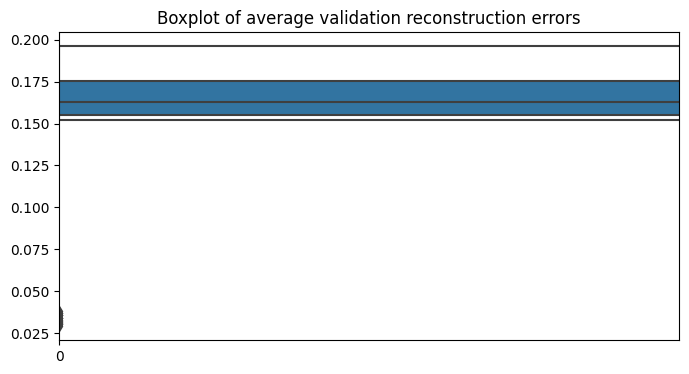

In [164]:
X3 = X3.reshape(X3.shape[0], X3.shape[2])  # reshape X3 to (8347, 81)
X4 = X4.reshape(X4.shape[0], X4.shape[2])  # reshape X4 to (8347, 81)

# perform detection

# get validation reconstruction errors
_, validation_errors = autoencoder.predict(test_X, test_Y)
#print(validation_errors)

# plot distribution of average validation reconstruction errors 
f, ax = plt.subplots(1, figsize = (8,4))
sns.boxplot(validation_errors.mean(axis=1), ax=ax)
ax.set_xlim([0,0.005])
ax.set_title('Boxplot of average validation reconstruction errors')


# set treshold as quantile of average reconstruction error
theta = validation_errors.mean(axis = 1).quantile(0.995)

Yhat3, _ = autoencoder.detect(X3, Y3_target, theta = theta , window = 3, average=True)
Yhat4, _ = autoencoder.detect(X4, Y4_target, theta = theta, window = 3, average=True)
print("Shapes of Yhat3 and Yhat4", Yhat3.shape, Yhat4.shape)
print("Shapes of Yhat3 and Yhat4", Yhat3, Yhat4)
print(Yhat3.min(), Yhat3.max())

In [165]:
Yhat3_1 = Yhat3*1
Yhat4_1 = Yhat4*1
results = pd.DataFrame(index = ['test dataset 01','test dataset 02'], 
                       columns = ['accuracy','f1_score','precision','recall','fpr'])
results.loc['test dataset 01'] = compute_scores(Y3[:-1],Yhat3_1)
results.loc['test dataset 02'] = compute_scores(Y4[:-1],Yhat4_1)


print('Results:\n')
print(results)
results.mean()


Results:

                 accuracy  f1_score precision    recall  fpr
test dataset 01  0.994247  0.997115         1  0.994247  NaN
test dataset 02  0.991364  0.995663         1  0.991364  NaN


C:\ProgramData\anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


accuracy     0.992806
f1_score     0.996389
precision    1.000000
recall       0.992806
fpr               NaN
dtype: float64

In [162]:
# Calculate prediction time per batch
batch_size = 32
prediction_times = []

for i in range(0, len(X3), batch_size):
    start_time_batch = time.time()

    X3_batch = X3[i:i + batch_size]
    Y3_batch = Y3_target[i:i + batch_size]

    _, _ = autoencoder.detect(X3_batch, Y3_batch, theta=theta, window=3, average=True)

    end_time_batch = time.time()
    prediction_time_batch = end_time_batch - start_time_batch
    prediction_times.append(prediction_time_batch)

average_prediction_time_per_batch = sum(prediction_times) / len(prediction_times)
average_prediction_time_per_batch = round(average_prediction_time_per_batch, 4)  # Round to 4 decimal places
print("Average prediction time per batch:", average_prediction_time_per_batch)

# Calculate prediction time per batch for X4
prediction_times_X4 = []

for i in range(0, len(X4), batch_size):
    start_time_batch = time.time()

    X4_batch = X4[i:i + batch_size]
    Y4_batch = Y4_target[i:i + batch_size]

    _, _ = autoencoder.detect(X4_batch, Y4_batch, theta=theta, window=3, average=True)

    end_time_batch = time.time()
    prediction_time_batch = end_time_batch - start_time_batch
    prediction_times_X4.append(prediction_time_batch)

average_prediction_time_per_batch_X4 = sum(prediction_times_X4) / len(prediction_times_X4)
average_prediction_time_per_batch_X4 = round(average_prediction_time_per_batch_X4, 4)  # Round to 4 decimal places
print("Average prediction time per batch for X4:", average_prediction_time_per_batch_X4)

1/1 [==============================] - 0s 21ms/step
Average prediction time per batch: 0.0491
1/1 [==============================] - 0s 20ms/step
Average prediction time per batch for X4: 0.0492
